In [2]:
import nltk; nltk.download('stopwords')
import re
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm.notebook import tqdm
from collections import Counter
import en_core_web_sm
from sklearn.metrics.pairwise import euclidean_distances

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maggi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

C:\Users\maggi\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
# spacy for lemmatization
import spacy
from spacy import displacy

In [5]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Logging
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


C:\Users\maggi\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
from nltk.corpus import stopwords

In [8]:
#note: stop word processing is in the wrong order
stop_words = stopwords.words('english')
more_stops = pd.read_csv('../data/more_stops.txt',delimiter = "\t")
more_stops = more_stops['stops'].tolist()
stop_words.extend(more_stops)
even_more_stops = ['mr','reply','say','go','see','know','get','look','do','take','tell','want','come',\
                  'feel','even','stand','turn','speak','yet','ever','word','back','day','live','rather',\
                  'miss','wish','bring','say','call','do','give','send','set','insist','several','next',\
                  'put','perhaps','thus','much','day','many','declare','other','show','sort','hold',\
                   'always','begin','meet','exclaim','says','said','goes','sees','knows','gets','looks'\
                  'does','takes','tells','wants','seen','seeing','saying', 'came','coming','comes','goes'\
                  'going','gone','hand','hands','handing','look','looks','looked','looking','making','made'\
                  'make','find','finds','good','know','knows','known','knew','knowing','takes','taken','taking'\
                  'think','thinks','thinking','thought','man','men','never','let','lets','does','doing','done'\
                  'did','speak','call','try','trying','tried','almost','woman','women','girl','girls',\
                  'boy','boys','sight','other','explain','explained','explains','want','wants','wanted',\
                  'went','sudden','exclaim','exclaimed','admit','admitted','somewhere','anywhere','everywhere'\
                   'hour','hours','year','years','time','times','ze','zat','plenty','ee','ois','eye','eyes',\
                   'head','heads','heading','door','doors','foot','feet','voice','voices','face','faces',\
                   'mind','minds','room','rooms','place','places','thing','things','week','weeks','talk',\
                   'talks','house','houses','day','days','end','ends','month','months','oclock','occasion',\
                   'occasions','feeling','feelings','use','uses','manner','manners','moment','moments','morrow'\
                   'morrows','kind','kinds','change','changes','changing','wot','ave','hmar','abaht','hif'\
                   'side','sides','morning','mornings','evening','evenings','rest','rests','senses','sense'\
                   'point','points','thought','thoughts','afternoon','afternoons','countenance','countenances'\
                   'group','groups','anon','derned','svell','moren','heerd','hall','halls','table','tables',\
                   'life','live','lives','father','fathers','friend','friends','night','nights'
                  ]
stop_words.extend(even_more_stops)
len(stop_words)

5800

In [10]:
#All Gutenberg metadata
metadata = pd.read_csv('../data/metadata/metadata.csv')

In [11]:
#Select detective/mystery fiction and tales in English, exclude juvenile
kw = ['fiction','tale']
subj = ['detective', 'mystery','mysteries']
not_sub = ['juvenile']
metadata = metadata[metadata['language']=='[\'en\']']
metadata = metadata[metadata['subjects'].apply(lambda x: any([k in x.lower() for k in kw]))]
metadata = metadata[metadata['subjects'].apply(lambda x: any([k in x.lower() for k in subj]))]
metadata = metadata[~metadata['subjects'].str.contains('Juvenile')]

In [12]:
len(metadata)

737

In [13]:
#Ids to list
ids = list(metadata['id'])

#List the ids and path for these titles
txts = [[id, '../data/text\\' + id + '_text.txt'] for id in ids]

#note any files that don't exist (duplicates or files that were not utf8) and remove them from the metadata df
docs = []

for idx, filename in tqdm(txts):
    try:
        with open(filename, 'r', encoding = 'utf8') as txt:
            # added encoding = 'utf8' to prevent a continuation byte error
            #txt = f
            #pdf = pdftotext.PDF(f)
            txt = '\n\n'.join(txt)#.lower()
            txt = re.sub('-\s+', '', txt)
            txt = re.sub('--',' ', txt)
            txt = re.sub("\'", "", txt)
            txt = ' '.join(re.findall('[a-zA-z\-]{2,}', txt))
            #txt = txt[0:50000]
            docs.append(txt)
    except FileNotFoundError:
        print('WARNING: file not found ', filename)
        metadata = metadata[metadata['id']!=idx]

#Does everything match?
print(len(metadata) == len(docs))
print(len(metadata))

  0%|          | 0/737 [00:00<?, ?it/s]

True
696


In [14]:
#Ids to list -- edited list of just the books that we found in our library
ids = list(metadata['id'])

In [518]:
# Save the edited metadata to retrieve later
metadata.to_csv('../data/model_data/dm_lda_04/metadata_lda04.csv', index = False)

In [15]:
docs[0]

'Proofreaders THE SECRET OF THE TOWER BY ANTHONY HOPE AUTHOR OF THE PRISONER OF ZENDA RUPERT OF HENTZAU ETC CONTENTS DOCTOR MARYS PAYING GUEST II THE GENERAL REMEMBERS III MR SAFFRON AT HOME IV PROFESSIONAL ETIQUETTE FAMILIAR IMPLEMENT VI ODD STORY OF CAPTAIN DUGGLE VII GENTLEMANLY STRANGER VIII CAPTAIN ALEC RAISES HIS VOICE IX DOCTOR MARYS ULTIMATUM THAT MAGICAL WORD MOROCCO XI THE CAR BEHIND THE TREES XII THE SECRET OF THE TOWER XIII RIGHT OF CONQUEST XIV THE SCEPTER IN THE GRAVE XV NORMAL CASE XVI DEAD MAJESTY XVII THE CHIEF MOURNERS XVIII THE GOLD AND THE TREASURE CHAPTER DOCTOR MARYS PAYING GUEST Just in time wasnt it asked Mary Arkroyd Two days before the the ceremony Mercifully it had all been kept very quiet because it was only three months since poor Gilly was killed forget whether you ever met Gilly My half-brother you know Only once in Collingham Gardens He had an _exeat_ and dashed in one Saturday morning when we were just finishing our work Dont you remember Yes think do B

In [16]:
#remove tag words with nltk and remove proper nouns and punctuation
#this seemed to work better than spacy for names, not sure why
def sent_to_words(sentences):
    for sentence in tqdm(sentences):
        tagged_words = nltk.tag.pos_tag(sentence.split())
        no_names = [word for word, tag in tagged_words if tag != 'NNP' and tag != 'NNPS'] # remove proper nouns
        yield(gensim.utils.simple_preprocess(str(no_names), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(docs))

#print(data_words[:1])

  0%|          | 0/696 [00:00<?, ?it/s]

In [26]:
#write out the file at this checkpoint
with open('../data/data_words.txt', 'w') as f:
    for item in data_words:
        f.write("%s\n" % item)

In [31]:
#read in the partly processed file
data_words = pd.read_csv('../data/data_words.txt',delimiter = "\t", header = None, names = ['words'])
data_words.head()

,words
0,"['proofreaders', 'the', 'of', 'of', 'of', 'in'..."
1,"['proofreading', 'of', 'with', 'by', 'to', 'fe..."
2,"['the', 'is', 'that', 'who', 'are', 'you', 'de..."
3,"['produced', 'by', 'illustration', 'the', 'by'..."
4,"['the', 'by', 'when', 'hath', 'conceived', 'it..."


In [32]:
data_words = data_words['words'].tolist()

In [119]:
data_words[0]

['proofreaders',
 'the',
 'of',
 'of',
 'of',
 'in',
 'time',
 'wasnt',
 'it',
 'asked',
 'two',
 'days',
 'before',
 'the',
 'the',
 'ceremony',
 'it',
 'had',
 'all',
 'been',
 'kept',
 'very',
 'quiet',
 'because',
 'it',
 'was',
 'only',
 'three',
 'months',
 'since',
 'poor',
 'was',
 'killed',
 'forget',
 'whether',
 'you',
 'ever',
 'met',
 'half',
 'brother',
 'you',
 'know',
 'only',
 'once',
 'in',
 'he',
 'had',
 'an',
 'and',
 'dashed',
 'in',
 'one',
 'morning',
 'when',
 'we',
 'were',
 'just',
 'finishing',
 'our',
 'work',
 'you',
 'remember',
 'yes',
 'think',
 'do',
 'but',
 'since',
 'my',
 'engagement',
 'gone',
 'into',
 'colors',
 'of',
 'course',
 'gone',
 'back',
 'into',
 'mourning',
 'now',
 'and',
 'everything',
 'was',
 'ready',
 'settlements',
 'and',
 'so',
 'on',
 'you',
 'know',
 'and',
 'rooms',
 'taken',
 'at',
 'and',
 'then',
 'it',
 'all',
 'came',
 'out',
 'mean',
 'think',
 'he',
 'really',
 'must',
 'have',
 'had',
 'shell',
 'shock',
 'as',
 'he

In [123]:
len(data_words)

696

In [41]:
#make a list that includes the index, links back to the original metadata and the PGID
my_list = []
for i in data_words:
    my_list.append(list([data_words.index(i), i]))

In [124]:
#break up each book entry into chunks of 1000 tokens, retaining the link to the previous list
n = 1000
data_words_chunked = []
for i in my_list:
    label = i[0]
    items = i[1]
    for j in range(0, len(items), n):
        expanded_item = list([label, items[j:j+n]])
        data_words_chunked.append(expanded_item)
len(data_words_chunked)

In [130]:
#the text chunks only
data_words_tomodel = []
for i in data_words_chunked:
    data_words_list = i[1]
    data_words_tomodel.append(data_words_list)

data_words_tomodel[0:20]


[['proofreaders',
  'the',
  'of',
  'of',
  'of',
  'in',
  'time',
  'wasnt',
  'it',
  'asked',
  'two',
  'days',
  'before',
  'the',
  'the',
  'ceremony',
  'it',
  'had',
  'all',
  'been',
  'kept',
  'very',
  'quiet',
  'because',
  'it',
  'was',
  'only',
  'three',
  'months',
  'since',
  'poor',
  'was',
  'killed',
  'forget',
  'whether',
  'you',
  'ever',
  'met',
  'half',
  'brother',
  'you',
  'know',
  'only',
  'once',
  'in',
  'he',
  'had',
  'an',
  'and',
  'dashed',
  'in',
  'one',
  'morning',
  'when',
  'we',
  'were',
  'just',
  'finishing',
  'our',
  'work',
  'you',
  'remember',
  'yes',
  'think',
  'do',
  'but',
  'since',
  'my',
  'engagement',
  'gone',
  'into',
  'colors',
  'of',
  'course',
  'gone',
  'back',
  'into',
  'mourning',
  'now',
  'and',
  'everything',
  'was',
  'ready',
  'settlements',
  'and',
  'so',
  'on',
  'you',
  'know',
  'and',
  'rooms',
  'taken',
  'at',
  'and',
  'then',
  'it',
  'all',
  'came',
  'o

In [131]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words_tomodel, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words_tomodel], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#print(trigram_mod[bigram_mod[data_words[0]]])

In [132]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [133]:
# Some of this needs to be rearranged

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words_tomodel)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
#data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN'])

#print(data_lemmatized[:1])

In [134]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
#print(corpus[:1])

In [135]:
#id2word[871]
print(str(id2word[11]), str(id2word.cfs[11])) 
id2word.save_as_text('../model_artifacts/id2word_dict04.txt')

brother 11742


In [149]:
# Human readable format of corpus (term-frequency)
#[[(id2word[id], freq) for id, freq in cp] for cp in corpus]
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[9:10]]

[[('bed', 1),
  ('bit', 1),
  ('cigarette', 1),
  ('color', 1),
  ('doubt', 3),
  ('examination', 1),
  ('fire', 3),
  ('influence', 1),
  ('letter', 1),
  ('lip', 1),
  ('mantelpiece', 1),
  ('money', 3),
  ('paper', 1),
  ('reference', 1),
  ('sense', 1),
  ('smile', 1),
  ('arm', 1),
  ('companion', 1),
  ('garden', 1),
  ('gate', 1),
  ('hair', 1),
  ('laugh', 1),
  ('mist', 1),
  ('resentment', 1),
  ('side', 1),
  ('wind', 1),
  ('chair', 2),
  ('matter', 1),
  ('news', 1),
  ('position', 1),
  ('sir', 1),
  ('car', 1),
  ('cousin', 2),
  ('difficulty', 1),
  ('fact', 1),
  ('invitation', 1),
  ('people', 2),
  ('person', 1),
  ('question', 1),
  ('suggestion', 1),
  ('touch', 1),
  ('trouble', 1),
  ('appearance', 1),
  ('box', 1),
  ('character', 1),
  ('lamp', 1),
  ('passage', 1),
  ('account', 1),
  ('jerk', 1),
  ('visit', 1),
  ('circumstance', 1),
  ('nod', 1),
  ('effect', 1),
  ('attack', 1),
  ('diplomacy', 1),
  ('history', 1),
  ('phrase', 3),
  ('acquaintance', 1),


In [137]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=500,
                                           passes=20,
                                           iterations = 400,
                                           alpha='auto',
                                           per_word_topics=True)
#num_topics = 6
#chunksize = 2000
#passes = 20
#iterations = 400
#eval_every = None  # Don't evaluate model perplexity, takes too much time.

In [390]:
# Save the model
#dir(lda_model)
lda_model.save('../data/model_data/dm_lda_04/model.lda04')

In [139]:
# Read the model back in
model = gensim.models.ldamodel.LdaModel.load('../data/model_data/dm_lda_04/model.lda04')

In [140]:
# Look for additional stop words
model.print_topics(num_words = 200)

[(0,
  '0.111*"manager" + 0.098*"island" + 0.074*"hedge" + 0.056*"traveller" + 0.049*"conspiracy" + 0.037*"cliff" + 0.035*"tent" + 0.033*"stage" + 0.030*"ch_teau" + 0.026*"theatre" + 0.021*"bicycle" + 0.020*"stall" + 0.019*"idol" + 0.017*"contradiction" + 0.016*"masterpiece" + 0.013*"goose" + 0.012*"compose" + 0.012*"stepmother" + 0.010*"tracing" + 0.010*"visage" + 0.009*"shopman" + 0.009*"sock" + 0.009*"limitation" + 0.009*"predecessor" + 0.008*"plucky" + 0.008*"tiller" + 0.008*"discredit" + 0.007*"condemnation" + 0.007*"narrator" + 0.006*"considering" + 0.006*"audience" + 0.005*"failing" + 0.005*"necessary" + 0.005*"guileless" + 0.005*"deep" + 0.004*"quondam" + 0.004*"richness" + 0.004*"enlarge" + 0.004*"prodigy" + 0.004*"speak" + 0.003*"women" + 0.003*"designing" + 0.003*"advisable" + 0.003*"performance" + 0.003*"amenity" + 0.003*"deprecating" + 0.002*"finishing_touche" + 0.002*"bushel" + 0.002*"bookshelf" + 0.002*"alertness" + 0.002*"invocation" + 0.002*"broadside" + 0.001*"cocksur

In [141]:
# Compute Perplexity
#print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.
print('\nPerplexity: ', model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score - ** needs to use model **
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.888046335508538

Coherence Score:  0.4267510079356208


In [176]:
# Visualize the topics
pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
#vis = gensimvis.prepare(model, corpus, id2word, mds = 'mmds')
vis = gensimvis.prepare(model, corpus, dictionary = model.id2word, mds = 'mmds')
#vis = gensimvis.prepare(model, corpus, dictionary, mds = 'mmds', sort_topics=False)

In [391]:
pyLDAvis.save_html(vis, '../data/model_data/dm_lda_04/lda04.html')
#vis

In [389]:
# Save 50 most important words per topic to data frame ... come back to this later
# For now, use the model itself
contents = []
for t in range(model.num_topics):
    word_weights = model.show_topic(t,50)
    contents.append(word_weights)
    
contents
fit_words = pd.DataFrame(contents)
fit_words

#for idx, tuple_list in enumerate(corpus):
#    topics = model.get_document_topics(corpus[idx])
#    for res in topics:
#        topic, pct = res
#        contents.append({'chunk':idx,'topic':topic, 'percent':pct})
#topics = pd.DataFrame(contents)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,"(manager, 0.11076207)","(island, 0.098153025)","(hedge, 0.07361885)","(traveller, 0.056315064)","(conspiracy, 0.049061053)","(cliff, 0.037216607)","(tent, 0.035317667)","(stage, 0.03328636)","(ch_teau, 0.029514303)","(theatre, 0.025690861)",...,"(women, 0.0033158504)","(designing, 0.0032317424)","(advisable, 0.0027911568)","(performance, 0.0027392986)","(amenity, 0.0026229038)","(deprecating, 0.0025559808)","(finishing_touche, 0.002343602)","(bushel, 0.002205276)","(bookshelf, 0.0021925643)","(alertness, 0.0021067723)"
1,"(sea, 0.12032595)","(ship, 0.11299291)","(boat, 0.108854696)","(board, 0.052233443)","(shore, 0.034076817)","(sand, 0.029515173)","(yacht, 0.02863983)","(wind, 0.027089685)","(coast, 0.026833396)","(vault, 0.024286382)",...,"(recommendation, 0.003677034)","(emerald, 0.0035019435)","(architecture, 0.0032956284)","(tier, 0.0029930652)","(profusion, 0.002991857)","(salt, 0.002869749)","(woodland, 0.002820378)","(boundary, 0.0027344038)","(cloud, 0.0025922349)","(worshipper, 0.002498478)"
2,"(work, 0.026939858)","(fellow, 0.02650584)","(lot, 0.020576492)","(captain, 0.01899662)","(country, 0.018378364)","(people, 0.018180672)","(game, 0.017511971)","(bit, 0.015837248)","(city, 0.014247753)","(world, 0.012712098)",...,"(stuff, 0.0051674386)","(count, 0.005010251)","(couple, 0.0048311446)","(gang, 0.0047372296)","(trip, 0.0045717093)","(right, 0.004558008)","(trick, 0.0044455645)","(business, 0.004255565)","(heir, 0.0042107105)","(trail, 0.004129547)"
3,"(glass, 0.018152816)","(chair, 0.017444547)","(hair, 0.017239057)","(dinner, 0.014363419)","(hat, 0.012740393)","(dress, 0.0117494175)","(ring, 0.011647202)","(smile, 0.010790914)","(people, 0.010218116)","(gentleman, 0.009397928)",...,"(ball, 0.004945368)","(pleasure, 0.0049307547)","(coffee, 0.0048654964)","(queer, 0.004822046)","(corner, 0.0048156274)","(companion, 0.0047957017)","(clock, 0.0046240054)","(appearance, 0.0046080253)","(dining, 0.004564175)","(supper, 0.0044306433)"
4,"(sir, 0.47706205)","(gentleman, 0.08509909)","(master, 0.052446425)","(butler, 0.030708818)","(madam, 0.021067815)","(baronet, 0.018529417)","(parlour, 0.013785342)","(servant, 0.013389305)","(bless, 0.011812945)","(blessing, 0.010217043)",...,"(slang, 0.0023038262)","(decorum, 0.0020051554)","(brilliance, 0.0019900613)","(trepidation, 0.0019109162)","(conveying, 0.0018842516)","(claws, 0.0017619588)","(mistress, 0.0017605601)","(matchless, 0.0017363875)","(outburst, 0.0017244593)","(embankment, 0.0017186891)"
5,"(dog, 0.20605905)","(church, 0.092695765)","(niece, 0.055909637)","(tower, 0.048981056)","(prayer, 0.047296546)","(groan, 0.032828707)","(clergyman, 0.02777912)","(chimney, 0.027607594)","(hearth, 0.020294959)","(remorse, 0.017991427)",...,"(lime, 0.0036128361)","(asperity, 0.0035281146)","(twopence, 0.0035249295)","(lark, 0.003390473)","(nightcap, 0.003264039)","(dicken, 0.0032146797)","(fond, 0.003095542)","(jerk, 0.0030570931)","(nearness, 0.0030219778)","(axis, 0.0028579053)"
6,"(money, 0.14994884)","(pound, 0.045354594)","(business, 0.040597085)","(lawyer, 0.034786098)","(diamond, 0.028676396)","(property, 0.026926052)","(bank, 0.02510883)","(thief, 0.02494776)","(attorney, 0.023970418)","(jewel, 0.023153285)",...,"(firm, 0.0051265457)","(coin, 0.005108471)","(loss, 0.004853284)","(fund, 0.0046609025)","(stock, 0.00428062)","(cost, 0.004276434)","(office, 0.0041904044)","(transaction, 0.004051024)","(payment, 0.0039543267)","(wealth, 0.003937931)"
7,"(cell, 0.096231185)","(poison, 0.07845159)","(pin, 0.047323957)","(laboratory, 0.043946404)","(pirate, 0.04149435)","(explosion, 0.036137354)","(powder, 0.032353163)","(needle, 0.028825223)","(tube, 0.028360875)","(apparatus, 0.024668168)",...,"(substance, 0.004639535)","(neatness, 0.0045869527)","(ordering, 0.004548961)","(tottering, 0.0044415)","(humming, 0.004412184)","(battery, 0.004320891)","(substitution, 0.0043074605)","(quantity, 0.0042705475)","(staccato, 0.

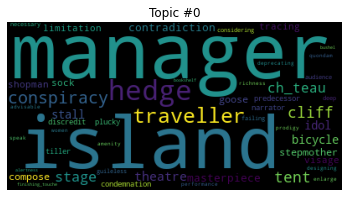

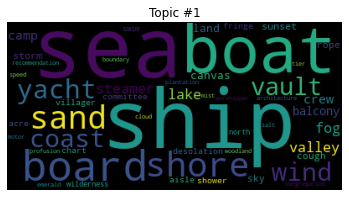

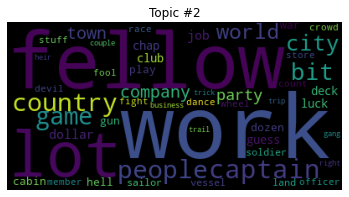

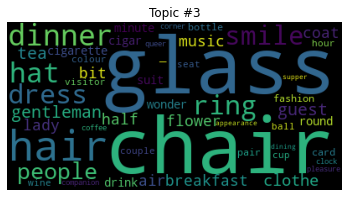

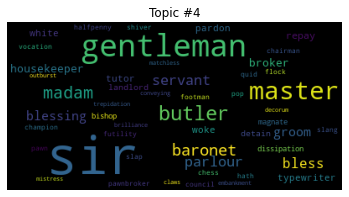

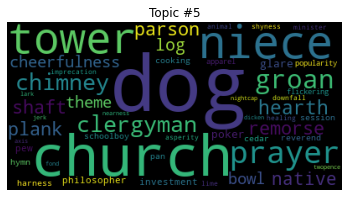

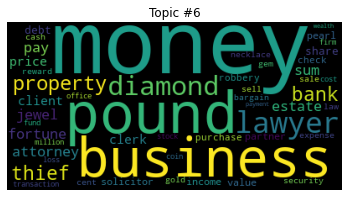

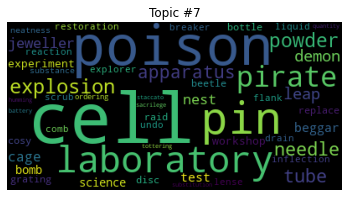

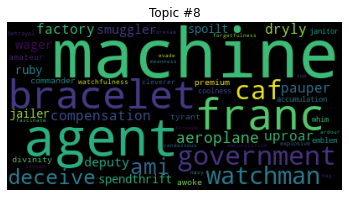

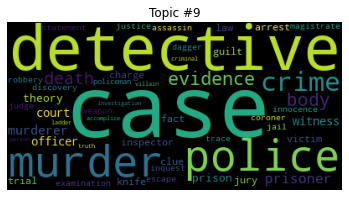

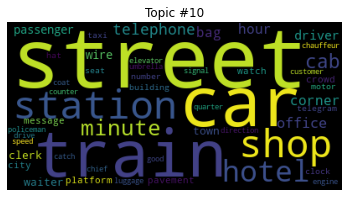

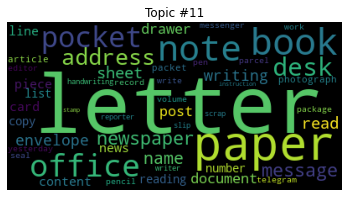

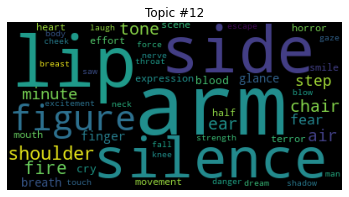

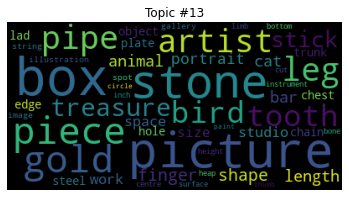

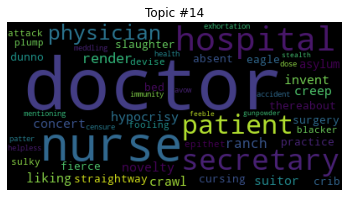

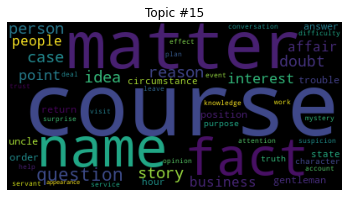

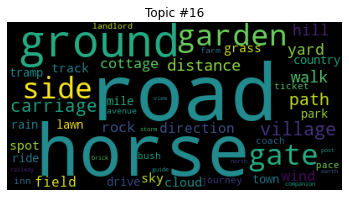

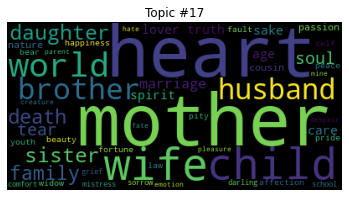

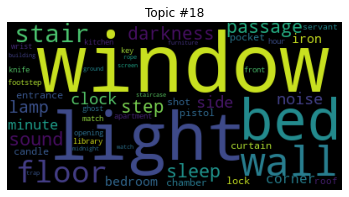

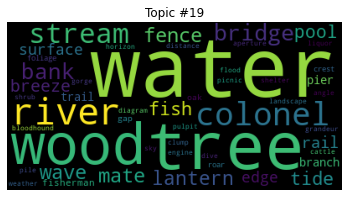

In [516]:
# Some more topic visualization
from wordcloud import WordCloud 
for t in range(model.num_topics):
    plt.figure()
    #plt.imshow(WordCloud().fit_words(model.show_topic(t, 200)))
    plt.imshow(WordCloud(background_color="black", prefer_horizontal = 1).fit_words(dict(model.show_topic(t, 50))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

In [152]:
model.get_document_topics(corpus[9])

[(2, 0.020588338),
 (3, 0.15150085),
 (5, 0.033157106),
 (6, 0.025439808),
 (9, 0.021100497),
 (10, 0.013157239),
 (11, 0.0416999),
 (12, 0.092376076),
 (13, 0.017258106),
 (15, 0.43220115),
 (16, 0.043806706),
 (17, 0.026900355),
 (18, 0.062901765)]

In [148]:
corpus[9]

[(8, 1),
 (10, 1),
 (21, 1),
 (24, 1),
 (30, 3),
 (33, 1),
 (37, 3),
 (48, 1),
 (54, 1),
 (55, 1),
 (57, 1),
 (62, 3),
 (66, 1),
 (79, 1),
 (84, 1),
 (89, 1),
 (104, 1),
 (115, 1),
 (133, 1),
 (134, 1),
 (139, 1),
 (148, 1),
 (156, 1),
 (170, 1),
 (177, 1),
 (194, 1),
 (209, 2),
 (243, 1),
 (246, 1),
 (257, 1),
 (268, 1),
 (292, 1),
 (299, 2),
 (302, 1),
 (306, 1),
 (318, 1),
 (332, 2),
 (333, 1),
 (337, 1),
 (351, 1),
 (354, 1),
 (355, 1),
 (362, 1),
 (368, 1),
 (371, 1),
 (397, 1),
 (406, 1),
 (441, 1),
 (467, 1),
 (510, 1),
 (521, 1),
 (551, 1),
 (604, 1),
 (651, 1),
 (661, 1),
 (672, 1),
 (687, 3),
 (712, 1),
 (713, 3),
 (714, 1),
 (715, 1),
 (716, 1),
 (717, 1),
 (718, 1),
 (719, 1),
 (720, 1),
 (721, 1),
 (722, 1),
 (723, 1),
 (724, 2),
 (725, 1),
 (726, 1),
 (727, 1),
 (728, 1),
 (729, 1),
 (730, 1),
 (731, 1),
 (732, 1),
 (733, 1),
 (734, 1),
 (735, 1),
 (736, 1),
 (737, 1),
 (738, 1),
 (739, 1),
 (740, 2),
 (741, 1),
 (742, 1),
 (743, 1),
 (744, 1),
 (745, 1),
 (746, 1),
 (747

In [173]:
model.get_topics()[:, 9]

array([2.72684360e-06, 8.40469511e-07, 1.52070683e-07, 6.98922959e-04,
       7.39671293e-07, 1.47523144e-06, 3.07187861e-07, 2.03079321e-06,
       2.50059179e-06, 1.68663931e-07, 2.69575025e-07, 1.85755198e-07,
       7.28960714e-08, 1.60220665e-07, 1.34612651e-06, 2.12421233e-04,
       2.22322839e-07, 1.00523735e-07, 1.46793724e-07, 7.95195092e-07],
      dtype=float32)

In [214]:
contents = []
for idx, tuple_list in enumerate(corpus):
    topics = model.get_document_topics(corpus[idx])
    for res in topics:
        topic, pct = res
        contents.append({'chunk':idx,'topic':topic, 'percent':pct})
topics = pd.DataFrame(contents)
topics.head()
    
    
    
    #model.get_document_topics(corpus[i])
    
    #for idx, val in enumerate(ints):
    #print(idx, val)

,chunk,topic,percent
0,0,2,0.024245
1,0,3,0.335994
2,0,6,0.064715
3,0,9,0.025076
4,0,10,0.023817


In [216]:
topics_pivot = topics.pivot(index = 'chunk', columns = 'topic', values = 'percent').fillna(0)

#Does everything match?
print(len(data_words_chunked) == len(topics_pivot))
print(len(topics_pivot))

topics_pivot.head()


True
44795


topic,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
chunk,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.0,0.024245,0.335994,0.000000,0.000000,0.064715,0.0,0.0,0.025076,0.023817,0.046920,0.087323,0.012901,0.029562,0.175014,0.015492,0.123468,0.024216,0.0
1,0.027266,0.0,0.054453,0.086837,0.000000,0.021409,0.000000,0.0,0.0,0.014384,0.014357,0.010361,0.133868,0.084914,0.028010,0.171166,0.188983,0.060241,0.082072,0.0
2,0.000000,0.0,0.191118,0.244753,0.000000,0.014889,0.027736,0.0,0.0,0.034197,0.000000,0.019202,0.067269,0.027531,0.000000,0.258730,0.023374,0.036719,0.020932,0.0
3,0.000000,0.0,0.156198,0.112592,0.000000,0.000000,0.012568,0.0,0.0,0.015333,0.047227,0.036610,0.109454,0.020651,0.022309,0.363447,0.022330,0.051970,0.018034,0.0
4,0.000000,0.0,0.097767,0.078724,0.048361,0.014712,0.000000,0.0,0.0,0.056668,0.000000,0.019249,0.075385,0.101844,0.000000,0.268072,0.015827,0.157048,0.042793,0.0


In [217]:
contents = []
for idx, lst in enumerate(data_words_chunked):
    doc_index = lst[0]
    contents.append(doc_index)
doc_indexes = pd.DataFrame(contents, columns = ['doc_index'])

#Does everything match?
print(len(doc_indexes) == len(topics_pivot))
print(len(topics_pivot))

doc_indexes.head()

True
44795


,doc_index
0,0
1,0
2,0
3,0
4,0


In [218]:
topics_pivot = doc_indexes.merge(topics_pivot, left_index = True, right_index = True)
print(len(topics_pivot))
topics_pivot.head()

44795


,doc_index,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,0,0.000000,0.0,0.024245,0.335994,0.000000,0.000000,0.064715,0.0,0.0,...,0.023817,0.046920,0.087323,0.012901,0.029562,0.175014,0.015492,0.123468,0.024216,0.0
1,0,0.027266,0.0,0.054453,0.086837,0.000000,0.021409,0.000000,0.0,0.0,...,0.014357,0.010361,0.133868,0.084914,0.028010,0.171166,0.188983,0.060241,0.082072,0.0
2,0,0.000000,0.0,0.191118,0.244753,0.000000,0.014889,0.027736,0.0,0.0,...,0.000000,0.019202,0.067269,0.027531,0.000000,0.258730,0.023374,0.036719,0.020932,0.0
3,0,0.000000,0.0,0.156198,0.112592,0.000000,0.000000,0.012568,0.0,0.0,...,0.047227,0.036610,0.109454,0.020651,0.022309,0.363447,0.022330,0.051970,0.018034,0.0
4,0,0.000000,0.0,0.097767,0.078724,0.048361,0.014712,0.000000,0.0,0.0,...,0.000000,0.019249,0.075385,0.101844,0.000000,0.268072,0.015827,0.157048,0.042793,0.0


In [219]:
# Save the df at this checkpoint for some excel-foo
topics_pivot.to_csv('../data/topics_pivot.csv')

In [301]:
topics_summary = topics_pivot.groupby('doc_index').mean().reset_index()
topics_summary.columns = ['topic_' + str(i) if ix > 0 else i for ix, i in enumerate(topics_summary.columns)]
print(len(topics_summary))

696


In [302]:
topics_summary.head()

,doc_index,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,0.002099,0.000328,0.075983,0.111052,0.006879,0.005760,0.027011,0.001206,0.002735,...,0.021455,0.025291,0.130951,0.050395,0.009008,0.290606,0.043932,0.069184,0.067990,0.005143
1,1,0.001172,0.006686,0.045212,0.063337,0.022029,0.000235,0.029929,0.010021,0.002776,...,0.036915,0.105833,0.140186,0.046200,0.001156,0.248974,0.015719,0.046573,0.084675,0.005638
2,2,0.002074,0.002601,0.031155,0.074460,0.021008,0.001451,0.015176,0.000000,0.003515,...,0.039292,0.055678,0.079571,0.036918,0.000277,0.264973,0.024837,0.053421,0.067036,0.004741
3,3,0.000000,0.000666,0.063976,0.100419,0.016767,0.001560,0.021734,0.000379,0.000675,...,0.023847,0.063837,0.095575,0.060068,0.003135,0.261102,0.057441,0.052551,0.050909,0.015607
4,4,0.000597,0.001484,0.025551,0.046569,0.022708,0.007099,0.006495,0.001405,0.000778,...,0.006505,0.032670,0.147046,0.030050,0.005407,0.291932,0.031601,0.190689,0.066801,0.002084


In [234]:
doc_pgids = pd.DataFrame(ids, columns = ['pg_id'])
print(len(doc_pgids))
doc_pgids.head()


696


,pg_id
0,PG10057
1,PG10067
2,PG10082
3,PG10110
4,PG10377


In [303]:
topics_summary = doc_pgids.merge(topics_summary, left_index = True, right_index = True)
print(len(topics_summary))
topics_summary.head()

696


,pg_id,doc_index,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,PG10057,0,0.002099,0.000328,0.075983,0.111052,0.006879,0.005760,0.027011,0.001206,...,0.021455,0.025291,0.130951,0.050395,0.009008,0.290606,0.043932,0.069184,0.067990,0.005143
1,PG10067,1,0.001172,0.006686,0.045212,0.063337,0.022029,0.000235,0.029929,0.010021,...,0.036915,0.105833,0.140186,0.046200,0.001156,0.248974,0.015719,0.046573,0.084675,0.005638
2,PG10082,2,0.002074,0.002601,0.031155,0.074460,0.021008,0.001451,0.015176,0.000000,...,0.039292,0.055678,0.079571,0.036918,0.000277,0.264973,0.024837,0.053421,0.067036,0.004741
3,PG10110,3,0.000000,0.000666,0.063976,0.100419,0.016767,0.001560,0.021734,0.000379,...,0.023847,0.063837,0.095575,0.060068,0.003135,0.261102,0.057441,0.052551,0.050909,0.015607
4,PG10377,4,0.000597,0.001484,0.025551,0.046569,0.022708,0.007099,0.006495,0.001405,...,0.006505,0.032670,0.147046,0.030050,0.005407,0.291932,0.031601,0.190689,0.066801,0.002084


In [519]:
#Save the summary to retrieve later
topics_summary.to_csv('../data/model_data/dm_lda_04/topics_summary.csv', index = False)

In [503]:
# Calculate euclidean distances for one book and output to a data frame
X_index = 409
X = np.array([topics_summary.iloc[X_index,2:]])
#print(X)
contents = []
for doc_index in range(len(topics_summary)):
    #print(doc_index)
    Y = np.array([topics_summary.iloc[doc_index, 2:]])
    dist = euclidean_distances(X,Y)[0][0]
    contents.append([doc_index, dist])
doc_dist = pd.DataFrame(contents, columns = ['doc_index', 'dist'])

In [504]:
doc_dist.sort_values('dist').head()

,doc_index,dist
409,409,0.000000
430,430,0.034541
558,558,0.034775
554,554,0.038132
536,536,0.038299


In [505]:
doc_list = doc_dist.sort_values('dist').head()['doc_index'].to_list()

In [506]:
pg_id_list = topics_summary[topics_summary['doc_index'].isin(doc_list)]['pg_id'].to_list()

In [507]:
meta_list = metadata[metadata['id'].isin(pg_id_list)][['id','title','author','downloads','subjects']]

In [508]:
meta_list

,id,title,author,downloads,subjects
36505,PG42905,Great Porter Square: A Mystery. v. 1,"Farjeon, B. L. (Benjamin Leopold)",7,"{'Detective and mystery stories', 'Fiction'}"
39188,PG4531,The Secret Passage,"Hume, Fergus",28,"{'Fiction', 'Detective and mystery stories, En..."
50512,PG55511,The Silver Bullet,"Hume, Fergus",31,"{'England -- Fiction', 'Detective and mystery ..."
51313,PG56233,The Purple Fern,"Hume, Fergus",31,"{'England -- Fiction', 'Detective and mystery ..."
51449,PG56356,The Scarlet Bat: A Detective Story,"Hume, Fergus",25,"{'Detective and mystery stories', 'Murder -- I..."


In [509]:
contents = []
for row in meta_list.iterrows():
    #print(row[1])
    pg_id = (row[1][0])
    subj = (row[1][4])
    subj = subj.replace('{','')
    subj = subj.replace('}','')
    subj = subj.split("', ")
    for item in subj:
        contents.append({'pg_id':pg_id,'subject':item.replace("'","")})
subjects = pd.DataFrame(contents)
subjects
    

,pg_id,subject
0,PG42905,Detective and mystery stories
1,PG42905,Fiction
2,PG4531,Fiction
3,PG4531,"Detective and mystery stories, English"
4,PG55511,England -- Fiction
5,PG55511,Detective and mystery stories
6,PG55511,Murder -- Investigation -- Fiction
7,PG56233,England -- Fiction
8,PG56233,Detective and mystery stories
9,PG56233,Murder -- Investigation -- Fiction


In [510]:
topics_summary[topics_summary['doc_index'].isin(doc_list)].sum()

pg_id        PG42905PG4531PG55511PG56233PG56356
doc_index                                  2487
topic_0                                0.008093
topic_1                                0.009977
topic_2                                0.255723
topic_3                                0.458677
topic_4                                0.055565
topic_5                                0.017694
topic_6                                0.174915
topic_7                                0.006267
topic_8                                0.007117
topic_9                                0.407877
topic_10                               0.090334
topic_11                               0.256155
topic_12                               0.560854
topic_13                               0.209691
topic_14                               0.031456
topic_15                               1.350891
topic_16                               0.131957
topic_17                               0.518731
topic_18                               0

In [443]:
contents = []
total_docs = len(topics_summary)
for ix, topic in enumerate(topics_summary.columns):
    if ix > 1:
        topic_docs_gt0pct = len(topics_summary[topics_summary[topic]>0.0][['pg_id','doc_index',topic]].sort_values(topic,ascending = False))
        pct_docs_gt0pct = topic_docs_gt0pct / total_docs
        topic_docs_gt5pct = len(topics_summary[topics_summary[topic]>0.05][['pg_id','doc_index',topic]].sort_values(topic,ascending = False))
        pct_docs_gt5pct = topic_docs_gt5pct / total_docs
        contents.append({'topic':topic,'topic_docs_gt0pct':topic_docs_gt0pct, 'pct_docs_gt0pct':pct_docs_gt0pct,\
                        'topic_docs_gt5pct':topic_docs_gt5pct, 'pct_docs_gt5pct':pct_docs_gt5pct,})
docs_per_topic = pd.DataFrame(contents)
docs_per_topic

,topic,topic_docs_gt0pct,pct_docs_gt0pct,topic_docs_gt5pct,pct_docs_gt5pct
0,topic_0,583,0.837644,0,0.000000
1,topic_1,676,0.971264,5,0.007184
2,topic_2,696,1.000000,422,0.606322
3,topic_3,696,1.000000,690,0.991379
4,topic_4,684,0.982759,1,0.001437
5,topic_5,666,0.956897,0,0.000000
6,topic_6,696,1.000000,49,0.070402
7,topic_7,651,0.935345,0,0.000000
8,topic_8,620,0.890805,0,0.000000
9,topic_9,696,1.000000,381,0.547414
